In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import json
import os

In [96]:
# Only needed for the first time
# def save_npz_with_metadata(npz_path, metadata):
#     # Load existing data from npz file
#     data = np.load(npz_path)
#     data_dict = {key: data[key] for key in data.files}
    
#     # Add metadata to the data dictionary
#     data_dict.update(metadata)

#     # Save the updated data back to npz file
#     np.savez(npz_path, **data_dict)
#     print(f"Saved metadata to {npz_path}")

# path = './'
# for root, dirs, files in os.walk(path):
#     for file in files:
#         file_path = os.path.join(root, file)
#         if file.endswith('.npz'):
#             metadata_file_name = file.replace('seg.npz', 'params.json')
#             metadata_file_path = os.path.join(root, 'metadata', metadata_file_name)
#             if os.path.exists(metadata_file_path):
#                 with open(metadata_file_path, 'r') as f:
#                     metadata = json.load(f)
#                 save_npz_with_metadata(file_path, metadata)
#             else:
#                 print(f"No metadata file found for {file_path}")

In [2]:
def plot_data(im_cardio, im_markers):
    plt.figure(figsize=(30, 10))
    plt.subplot(141)
    plt.imshow(im_cardio)
    plt.subplot(142)
    plt.imshow(im_markers)
    plt.subplot(143)

    im_markers = im_markers.astype(np.uint8)
    # print(np.unique(im_cardio))
    im_cardio = cv2.resize(im_cardio, (640, 640), interpolation=cv2.INTER_NEAREST)
    im_markers = cv2.resize(im_markers, (640, 640), interpolation=cv2.INTER_NEAREST)

    _, blank_areas = cv2.threshold(im_cardio, 0, 255, cv2.THRESH_BINARY)
    # plt.imshow(blank_areas)
    im_markers = cv2.bitwise_and(im_markers, im_markers, mask=blank_areas.astype(np.uint8))

    plt.imshow(im_cardio)
    plt.imshow(im_markers, alpha=0.5)

    plt.subplot(144)
    plt.imshow(blank_areas)
    plt.show()

def compare_padding(im_cardio, im_markers1, im_markers2):
    im_cardio = cv2.resize(im_cardio, (640, 640), interpolation=cv2.INTER_NEAREST)
    im_markers1 = cv2.resize(im_markers1, (640, 640), interpolation=cv2.INTER_NEAREST)
    im_markers2 = cv2.resize(im_markers2, (640, 640), interpolation=cv2.INTER_NEAREST)

    plt.figure(figsize=(15, 10))
    plt.subplot(121)
    plt.imshow(im_cardio, alpha=1)
    plt.imshow(im_markers1, alpha=0.5)
    plt.subplot(122)
    plt.imshow(im_cardio, alpha=1)
    plt.imshow(im_markers2, alpha=0.5)
    plt.show()

In [3]:
def _get_slicer(shape, scale, translation):
    start_mic = np.array((max(translation[1], 0),
                max(translation[0], 0)))
    end_mic = np.flipud((translation + scale))

    cardio_scale = (80 / scale[0])

    start_cardio = np.abs((min(0, translation[1]), min(0, translation[0])))
    over_reach = (-(shape - np.flipud(scale + translation))).clip(min=0)
    end_cardio = np.flipud(scale) - over_reach

    mic_slice = (slice(start_mic[0], end_mic[0]), slice(start_mic[1], end_mic[1]))
    # cardio_slice = (slice(start_cardio[0], end_cardio[0]), slice(start_cardio[1], end_cardio[1]))
    cardio_slice = (slice(int(start_cardio[0] * cardio_scale), int(end_cardio[0] * cardio_scale)), slice(int(start_cardio[1] * cardio_scale), int(end_cardio[1] * cardio_scale)))

    return cardio_slice, mic_slice

def get_slicer(shape, scale, translation):
    start_mic = np.array((max(translation[1], 0),
                max(translation[0], 0)))
    end_mic = np.flipud((translation + scale))

    cardio_scale = (80 / scale[0])

    start_cardio = np.abs((min(0, translation[1]), min(0, translation[0])))
    over_reach = (-(shape - np.flipud(scale + translation))).clip(min=0)
    end_cardio = np.flipud(scale) - over_reach

    mic_slice = (slice(start_mic[0], end_mic[0]), slice(start_mic[1], end_mic[1]))
    cardio_slice = (slice(int(start_cardio[0] * cardio_scale), int(end_cardio[0] * cardio_scale)), slice(int(start_cardio[1] * cardio_scale), int(end_cardio[1] * cardio_scale)))

    return cardio_slice, mic_slice

def get_padding(scale, cardio_shape, mask_shape):
    cardio_pad = ((0, 80 - cardio_shape[0]), (0, 80 - cardio_shape[1]))

    up_scale_factor = scale / 80
    mask_pad1 = ((0, int(up_scale_factor * cardio_pad[0][1])), (0, int(up_scale_factor * cardio_pad[1][1])))
    mask_pad2 = ((0, scale - mask_shape[0]), (0, scale - mask_shape[1]))

    return cardio_pad, mask_pad1, mask_pad2

In [2]:
def plot_biosen(bio):
    plt.figure(figsize=(30, 10))
    for i in range(bio.shape[0]):
        plt.subplot(1, bio.shape[0], i + 1)
        plt.imshow(bio[i])
    plt.show()

def subsample_cardio(cardio, subsampled_length):
    original_length = cardio.shape[0]
    indices = np.linspace(0, original_length - 1, subsampled_length + 1, dtype=int)
    return cardio[indices[1:]]

def get_slicer(shape, scale, translation):
    start_mic = np.array((max(translation[1], 0), max(translation[0], 0)))
    end_mic = np.flipud((translation + scale))

    cardio_scale = (80 / scale[0])

    start_cardio = np.abs((min(0, translation[1]), min(0, translation[0])))
    over_reach = (-(shape - np.flipud(scale + translation))).clip(min=0)
    end_cardio = np.flipud(scale) - over_reach

    mic_slice = (slice(start_mic[0], end_mic[0]), slice(start_mic[1], end_mic[1]))
    cardio_slice = (slice(None),
                    slice(int(start_cardio[0] * cardio_scale), int(end_cardio[0] * cardio_scale)),
                    slice(int(start_cardio[1] * cardio_scale), int(end_cardio[1] * cardio_scale)))

    return cardio_slice, mic_slice

def get_padding(scale, cardio_shape, mask_shape):
    cardio_pad = ((0, 0), (0, 80 - cardio_shape[0]), (0, 80 - cardio_shape[1]))
    mask_pad = ((0, scale - mask_shape[0]), (0, scale - mask_shape[1]))

    return cardio_pad, mask_pad

def get_data_from_file(file):
    data = np.load(file)
    well, mask = data['well'], data['im_markers']
    scale, t_0, t_1 = int(data['scale']), int(data['t_0']), int(data['t_1'])

    slicer = get_slicer(mask.shape, (scale, scale), np.array([t_0, t_1]))

    cardio_max = np.max(well, axis=0)
    cardio = subsample_cardio(well, 1)
    # print(cardio.shape)
    cardio = cardio[slicer[0]]
    # plot_biosen(cardio)
    mask = mask[slicer[1]]

    if cardio.shape[1] != 80 or cardio.shape[2] != 80 or mask.shape[0] != scale or mask.shape[1] != scale:
        cardio_pad, mask_pad = get_padding(scale, cardio.shape, mask.shape)
        cardio = np.pad(cardio, cardio_pad, mode='constant', constant_values=0)
        mask = np.pad(mask, mask_pad, mode='constant', constant_values=0)

    _, blank_areas = cv2.threshold(cardio_max, 0, 1, cv2.THRESH_BINARY)
    blank_areas = cv2.resize(blank_areas, (scale, scale), interpolation=cv2.INTER_NEAREST)
    plt.imshow(blank_areas)
    plt.show()
    mask = mask.astype(np.uint16)
    # print(len(np.unique(mask)), len(np.unique(im_markers)))
    mask = cv2.bitwise_and(mask, mask, mask=blank_areas.astype(np.uint8))

    return cardio, mask

def plot_data(im_cardio, im_markers):
    plt.figure(figsize=(30, 10))
    plt.subplot(141)
    plt.imshow(im_cardio)
    plt.subplot(142)
    plt.imshow(im_markers)
    plt.subplot(143)

    im_markers[im_markers > 0] = 1
    im_cardio = cv2.resize(im_cardio, (640, 640), interpolation=cv2.INTER_NEAREST)
    im_markers = cv2.resize(im_markers, (640, 640), interpolation=cv2.INTER_NEAREST)

    plt.imshow(im_cardio)
    plt.imshow(im_markers, alpha=0.5)
    plt.show()



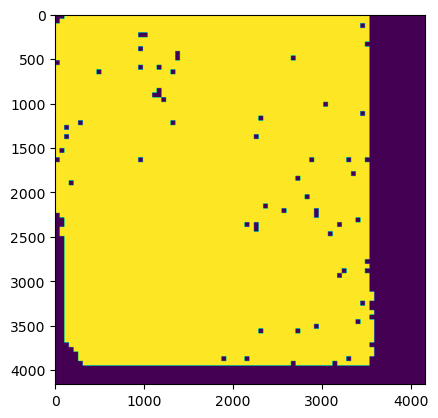

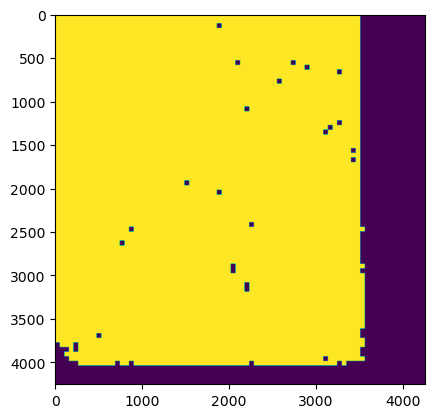

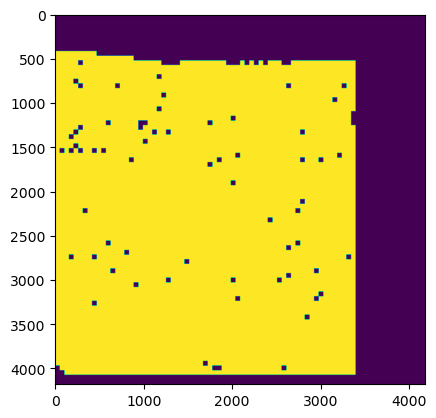

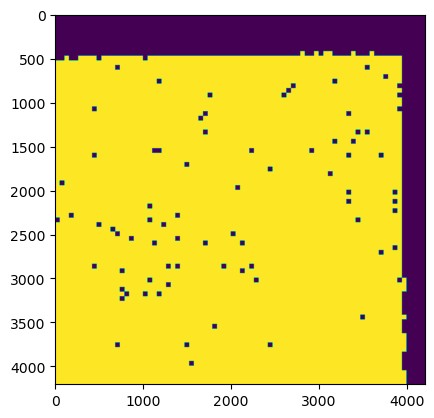

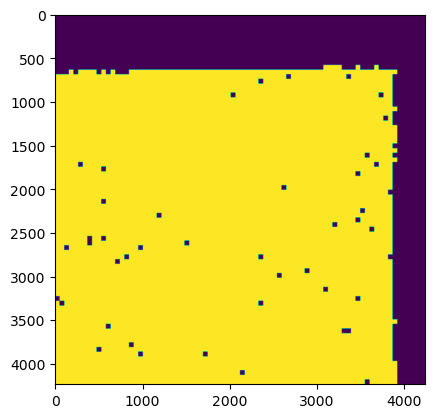

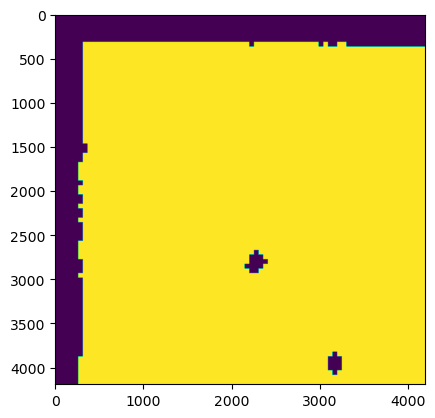

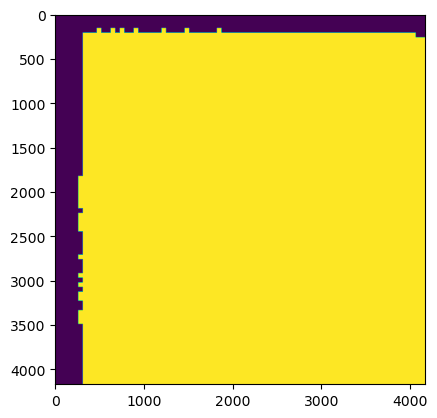

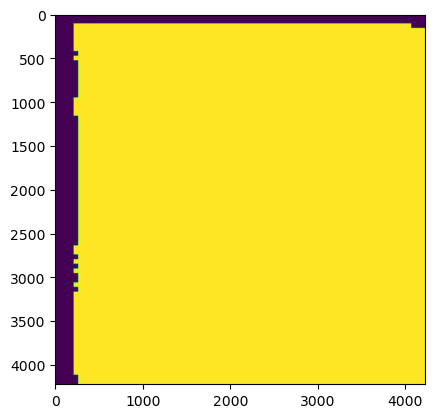

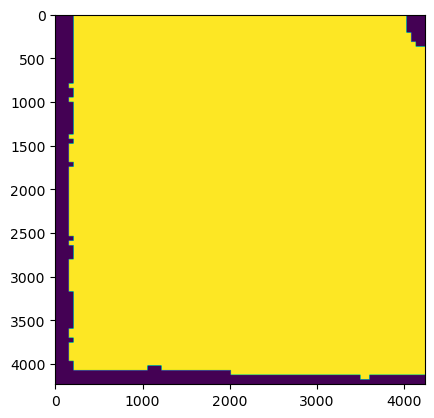

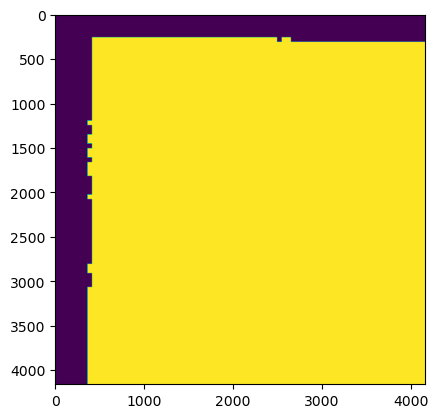

KeyboardInterrupt: 

In [3]:
path = './'
for root, dirs, files in os.walk(path):
    for file in files:
        file_path = os.path.join(root, file)
        if file.endswith('.npz'):

            cardio, mask = get_data_from_file(file_path)
            # print(cardio.shape, mask.shape)
            # plot_data(cardio[-1], mask)

            # seg = np.load(file_path, allow_pickle=True)
            # well, im_markers = seg['well'], seg['im_markers']
            # scale, t_0, t_1 = int(seg['scale']), int(seg['t_0']), int(seg['t_1'])
            # im_markers[im_markers > 0] = 1

            # slicer = get_slicer(im_markers.shape, (scale, scale), np.array([t_0, t_1]))
            # # im_cardio = well[-1]
            # im_cardio = np.max(well, axis=0)

            # cardio = im_cardio[slicer[0]]
            # mask = im_markers[slicer[1]]

            # # plot_data(im_cardio, im_markers)
            # if cardio.shape[0] != 80 or cardio.shape[1] != 80 or mask.shape[0] != scale or mask.shape[1] != scale:
            #     print(cardio.shape, mask.shape, scale, slicer)

            # compare_padding(im_cardio, im_markers, im_markers)
            # if im_cardio.shape[0] != 80 or im_cardio.shape[1] != 80:
            #     cardio_pad, mask_pad1, mask_pad2 = get_padding(scale, im_cardio.shape, im_markers.shape)

            #     im_cardio = np.pad(im_cardio, cardio_pad, mode='constant', constant_values=0)
            #     im_markers1 = np.pad(im_markers, mask_pad1, mode='constant', constant_values=0)
            #     im_markers = np.pad(im_markers, mask_pad2, mode='constant', constant_values=0)

            #     print(im_cardio.shape, im_markers1.shape, im_markers.shape, slicer)
                # compare_padding(im_cardio, im_markers1, im_markers2)

            # plot_data(im_cardio, im_markers)

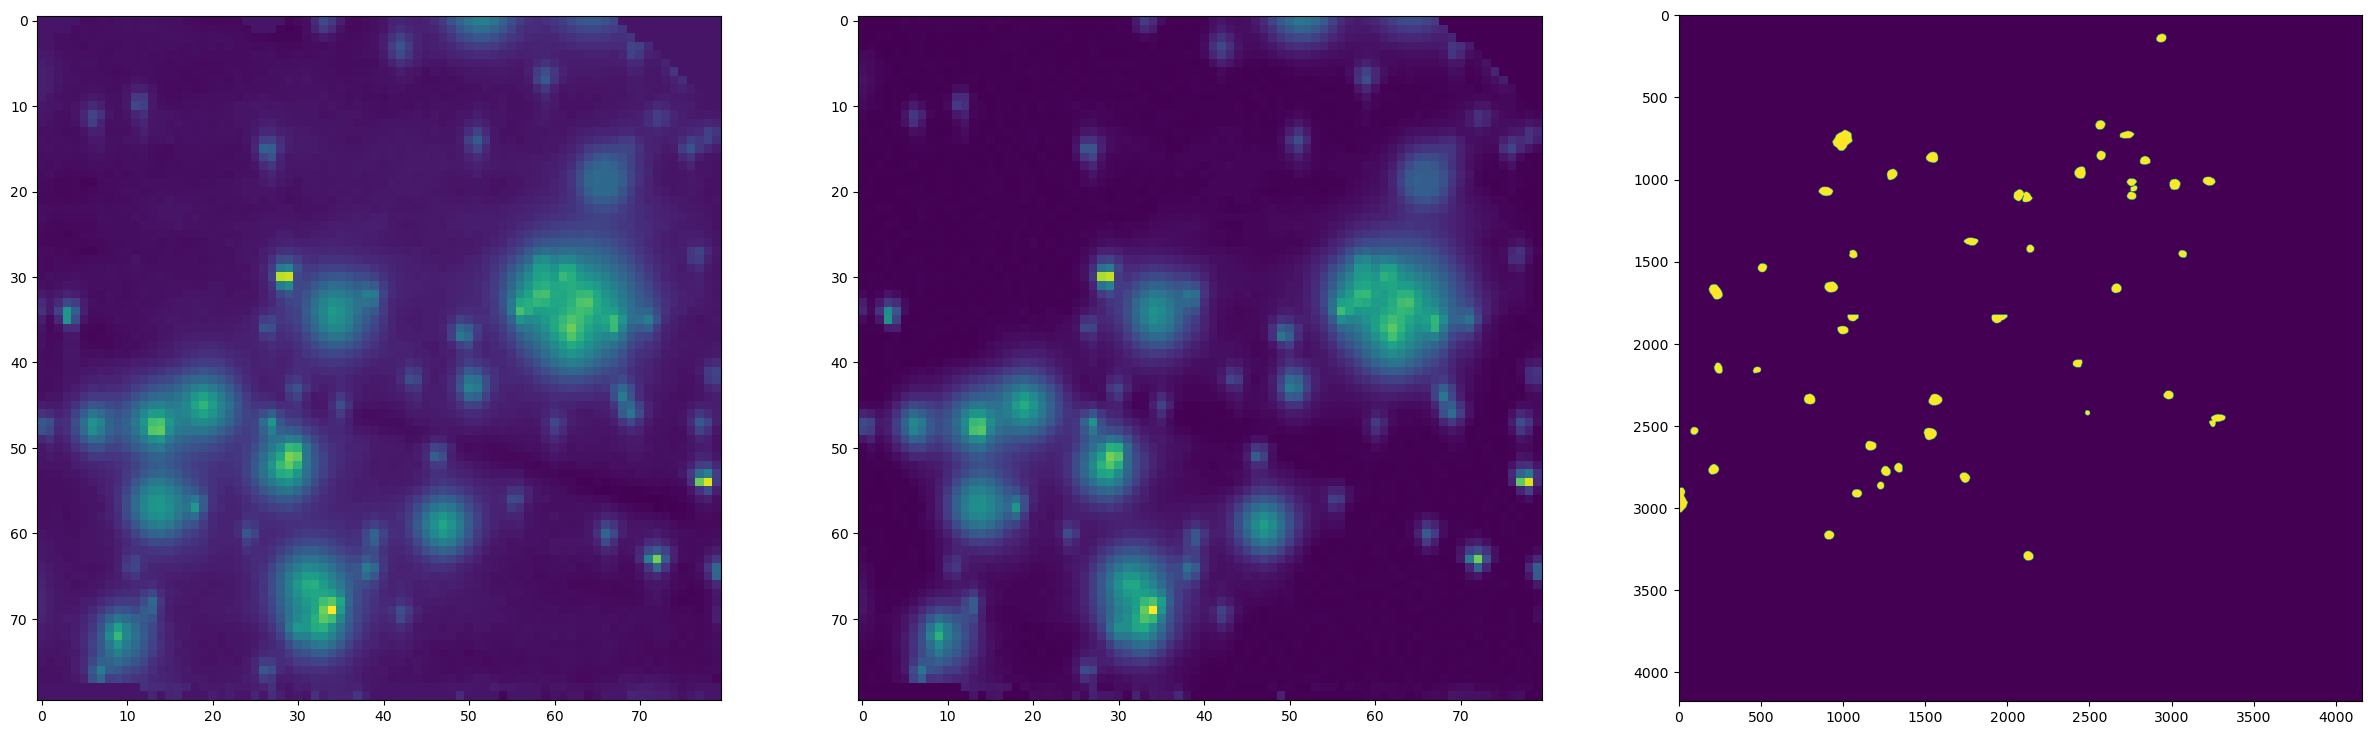

In [117]:
im_cardio = well[-1]
im_cardio2 = np.max(well, axis=0)
plot_data(im_cardio, im_cardio2, im_markers)

In [32]:
# segment_path = './fibronectin/20210526_LCLC_fn/B3_seg.npz'
# segment_path = './noncoated/20210408_MDAMB231_HepG2_nonc/C3_seg.npz'
path = './fibronectin/20200722_Preo_Hela_fn/A4_seg.npz'

seg = np.load(path, allow_pickle=True)
# im_cardio, im_watershed, im_cover, im_pred = seg['cardio'], seg['cardio_watershed'], seg['cardio_cover'], seg['cardio_pred']
# print(seg.files)
well, im_markers, im_mic = seg['well'], seg['im_markers'], seg['im_mic']
scale, t_0, t_1 = int(seg['scale']), int(seg['t_0']), int(seg['t_1'])
print(scale, t_0, t_1)
im_markers[im_markers > 0] = 1

# plot_data(well[-1], im_markers, im_mic)

slicer = _get_slicer(im_markers.shape, (scale, scale), np.array([t_0, t_1]))
print(slicer)
im_cardio = well[-1]
im_cardio = np.max(well, axis=0)

im_cardio = im_cardio[slicer[0]]
im_markers = im_markers[slicer[1]]
im_mic = im_mic[slicer[1]]

cardio_pad, mask_pad1, mask_pad2 = get_padding(scale, im_cardio.shape, im_markers.shape)

im_cardio = np.pad(im_cardio, cardio_pad, mode='constant', constant_values=0)
im_markers1 = np.pad(im_markers, mask_pad1, mode='constant', constant_values=0)
im_markers2 = np.pad(im_markers, mask_pad2, mode='constant', constant_values=0)

# print(im_cardio.shape, im_markers1.shape, im_markers2.shape)
# plot_data(im_cardio, im_markers1)
# compare_padding(im_cardio, im_markers1, im_markers2)

4159 1283 475
((slice(0, 80, None), slice(0, 80, None)), (slice(475, 4634, None), slice(1283, 5442, None)))


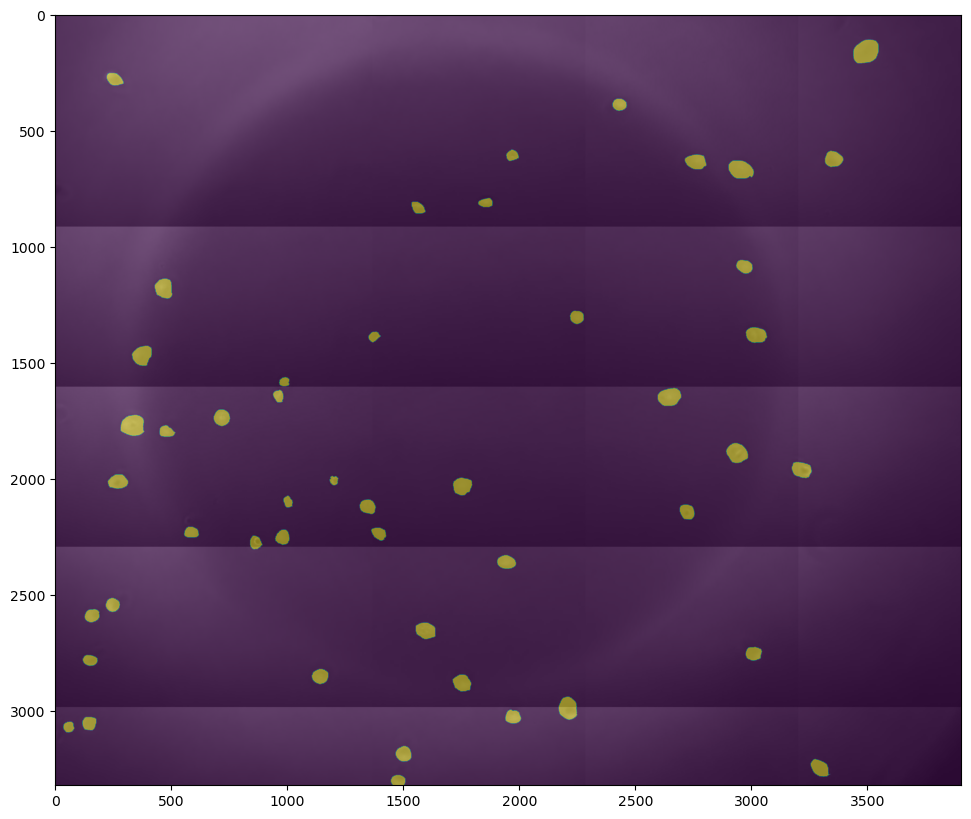

In [67]:
plt.figure(figsize=(30, 10))
plt.imshow(im_mic)
plt.imshow(im_markers, alpha=0.5)
plt.show()